<a href="https://colab.research.google.com/github/DavidCastro88/SalesTimeSeriesPrediction/blob/main/TimeSeriesPredictionRFLSTMProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicción de las ventas en el dominio de fabricación de calzado en Colombia (Indices empalmados)***

In [ ]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Modelo RandomForest
from sklearn.ensemble import RandomForestRegressor

#LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import tensorflow as tf

#Prophet Model
from prophet import Prophet

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error

from statsmodels.tools.eval_measures import rmse
from sklearn import metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
                             )
# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/Data.csv",delimiter = ";", encoding="latin1")
data.head()

,Dominio,Year,Month,Industrial class,nominal_production,real_production,nominal_sales,real_sales,total_employeement
0,1520,2001,1,Fabricación de calzado,33.0104,52.9457,33.0483,52.6265,112.0691
1,1520,2001,2,Fabricación de calzado,42.9887,67.2192,38.2210,59.9102,127.5592
2,1520,2001,3,Fabricación de calzado,49.7737,77.1464,48.7100,75.6003,135.7389
3,1520,2001,4,Fabricación de calzado,46.4394,70.9980,47.8570,72.8712,138.4528
4,1520,2001,5,Fabricación de calzado,52.5256,78.3284,56.2824,84.0249,149.0617


In [ ]:
data = data.drop(columns=['Dominio','Industrial class'],axis=1)
data.head()

,Year,Month,nominal_production,real_production,nominal_sales,real_sales,total_employeement
0,2001,1,33.0104,52.9457,33.0483,52.6265,112.0691
1,2001,2,42.9887,67.2192,38.2210,59.9102,127.5592
2,2001,3,49.7737,77.1464,48.7100,75.6003,135.7389
3,2001,4,46.4394,70.9980,47.8570,72.8712,138.4528
4,2001,5,52.5256,78.3284,56.2824,84.0249,149.0617


In [ ]:
data['date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-01')
data

,Year,Month,nominal_production,real_production,nominal_sales,real_sales,total_employeement,date
0,2001,1,33.0104,52.9457,33.0483,52.6265,112.0691,2001-01-01
1,2001,2,42.9887,67.2192,38.2210,59.9102,127.5592,2001-02-01
2,2001,3,49.7737,77.1464,48.7100,75.6003,135.7389,2001-03-01
3,2001,4,46.4394,70.9980,47.8570,72.8712,138.4528,2001-04-01
4,2001,5,52.5256,78.3284,56.2824,84.0249,149.0617,2001-05-01
...,...,...,...,...,...,...,...,...
275,2023,12,107.0715,85.0089,177.4377,141.5664,81.7292,2023-12-01
276,2024,1,93.6343,73.8487,115.0803,90.8593,79.0363,2024-01-01
277,2024,2,126.5477,98.3452,106.5562,82.6916,81.5534,2024-02-01
278,2024,3,110.0452,85.6014,99.1156,77.0347,82.2806,2024-03-01


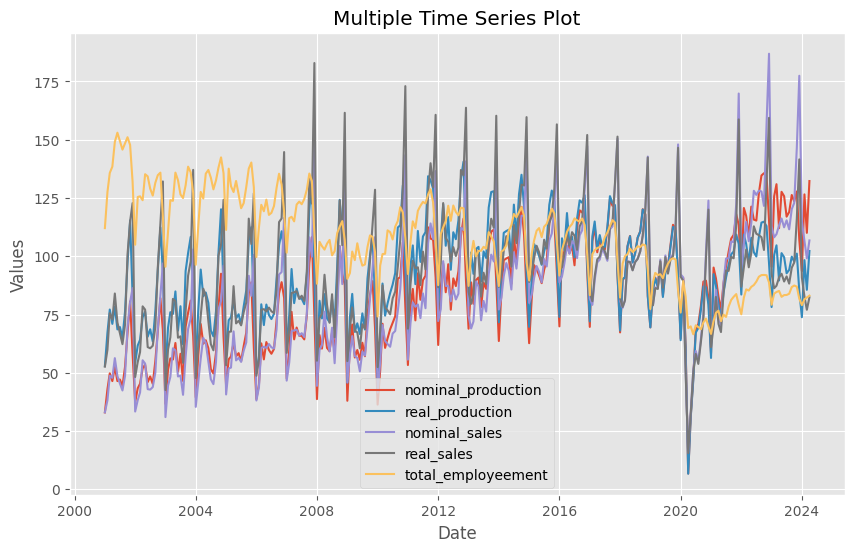

In [ ]:
df=data.copy()
df.drop(['Year','Month'],axis=1,inplace=True)
df.set_index('date', inplace=True)
plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Multiple Time Series Plot')
plt.legend()
plt.show()

In [ ]:
sales = data[['date','nominal_sales']]
sales.head()

,date,nominal_sales
0,2001-01-01,33.0483
1,2001-02-01,38.2210
2,2001-03-01,48.7100
3,2001-04-01,47.8570
4,2001-05-01,56.2824


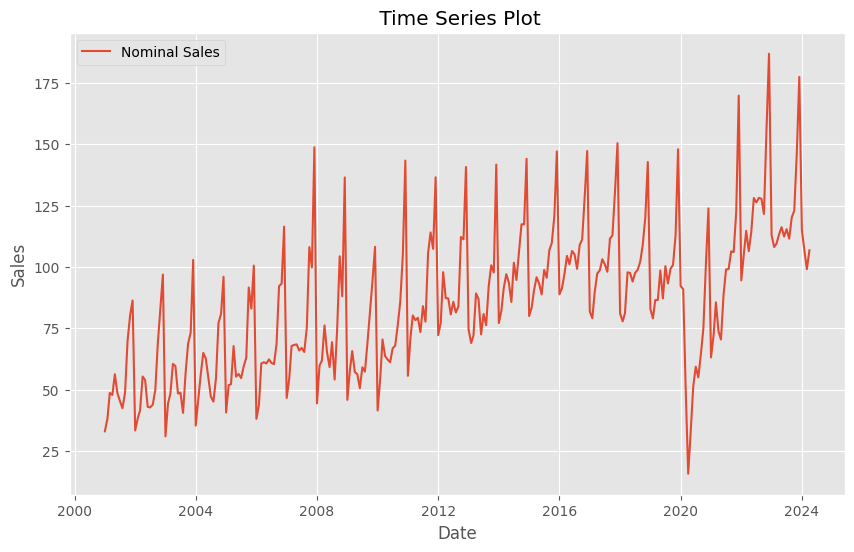

In [ ]:
data.set_index('date', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['nominal_sales'], label='Nominal Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(' Time Series Plot')
plt.legend()
plt.show()

In [ ]:
data.index.freq = 'MS'

## ***SARIMA MODELS***

In [ ]:
fig = px.line(data, x=data.index, y="nominal_sales",template = "plotly_dark",
              title="Sales Shoe Manufacturing")
fig.show()

### ***We verify stationarity***

Hipótesis Nula (): La serie temporal tiene una unidad raíz (es no estacionaria).

Hipótesis Alternativa (): La serie temporal no tiene una unidad raíz (es estacionaria).

In [ ]:
result = adfuller(data['nominal_sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6351948457587853
p-value: 0.4647727125855141


In [ ]:
data1=data.copy()
data1['nominal_sales_diff'] = data1['nominal_sales'].diff()
data1.dropna(inplace=True)
data1.head()

,Year,Month,nominal_production,real_production,nominal_sales,real_sales,total_employeement,nominal_sales_diff
date,,,,,,,,
2001-02-01,2001,2,42.9887,67.2192,38.2210,59.9102,127.5592,5.1727
2001-03-01,2001,3,49.7737,77.1464,48.7100,75.6003,135.7389,10.4890
2001-04-01,2001,4,46.4394,70.9980,47.8570,72.8712,138.4528,-0.8530
2001-05-01,2001,5,52.5256,78.3284,56.2824,84.0249,149.0617,8.4254
2001-06-01,2001,6,46.4489,68.6117,48.6065,71.6093,153.0157,-7.6759


In [ ]:
result = adfuller(data1['nominal_sales_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.826949938148272
p-value: 0.0026433095480861714


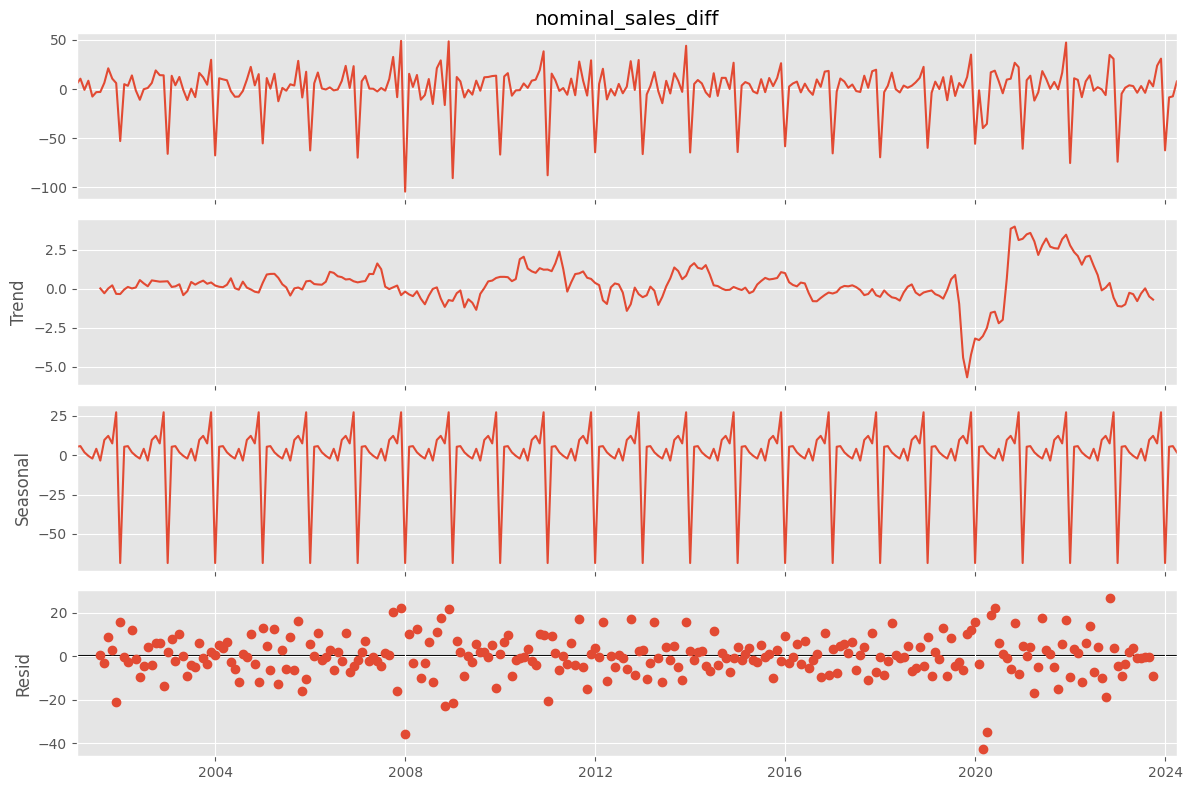

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
img = seasonal_decompose(data1["nominal_sales_diff"], model = "add")
img.plot();

In [ ]:
data = data[['nominal_sales']]

In [ ]:
train_data = data[:len(data)-12]
test_data = data[len(data)-12:]
test=test_data.copy()

In [ ]:
train_data.shape, test_data.shape

((268, 1), (12, 1))

In [ ]:
test_data

,nominal_sales
date,
2023-05-01,116.2044
2023-06-01,112.4190
2023-07-01,115.4120
2023-08-01,111.5476
2023-09-01,120.2116
2023-10-01,122.8735
2023-11-01,146.5633
2023-12-01,177.4377
2024-01-01,115.0803


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00


In [ ]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [ ]:
modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1955.502, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1900.670, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1857.530, Time=1.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1933.001, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1857.513, Time=2.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1893.527, Time=1.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1859.081, Time=5.00 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1858.527, Time=5.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1857.286, Time=3.35 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1884.793, Time=2.34 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1854.534, Time=4.30 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1855.461, Time=1.44 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1855.174, Time=7.15 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1854.829, Time=2.99 sec
 ARIMA(1,1,0)(0,1,2

In [ ]:
print(modelo_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  268
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -922.267
Date:                                 Thu, 04 Jul 2024   AIC                           1854.534
Time:                                         01:21:11   BIC                           1872.240
Sample:                                     01-01-2001   HQIC                          1861.656
                                          - 04-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3056      0.111      2.764      0.006       0.089       0

In [ ]:
arima_model = SARIMAX(train_data["nominal_sales"], order = (1,1,1), seasonal_order = (0,1,2,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           nominal_sales   No. Observations:                  268
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -922.267
Date:                                 Thu, 04 Jul 2024   AIC                           1854.534
Time:                                         01:21:17   BIC                           1872.240
Sample:                                     01-01-2001   HQIC                          1861.656
                                          - 04-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3056      0.111      2.764      0.006       0.089       0.522
ma.L1         -0.6675      0.103     -6.452      0.000      -0.870      -0.465
ma.S.L12      -0.6229      0.045    -13.720      0.000      -0.712      -0.534
ma.S.L24      -0.1174      0.063     -1.875      0.061      -0.240       0.005
sigma2        78.3235      3.906     20.051      0.000      70.667      85.980
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               755.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

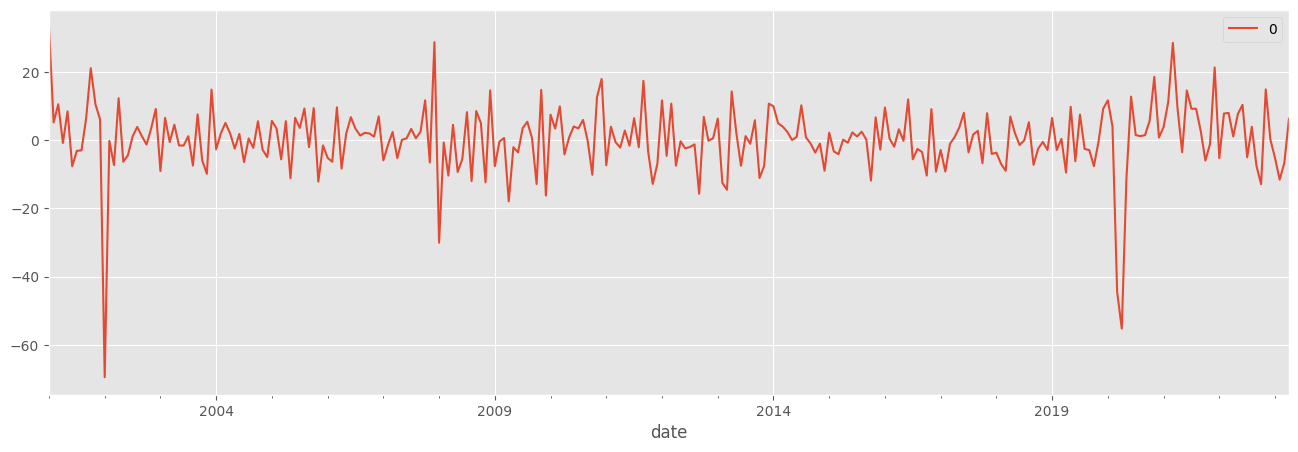

In [ ]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

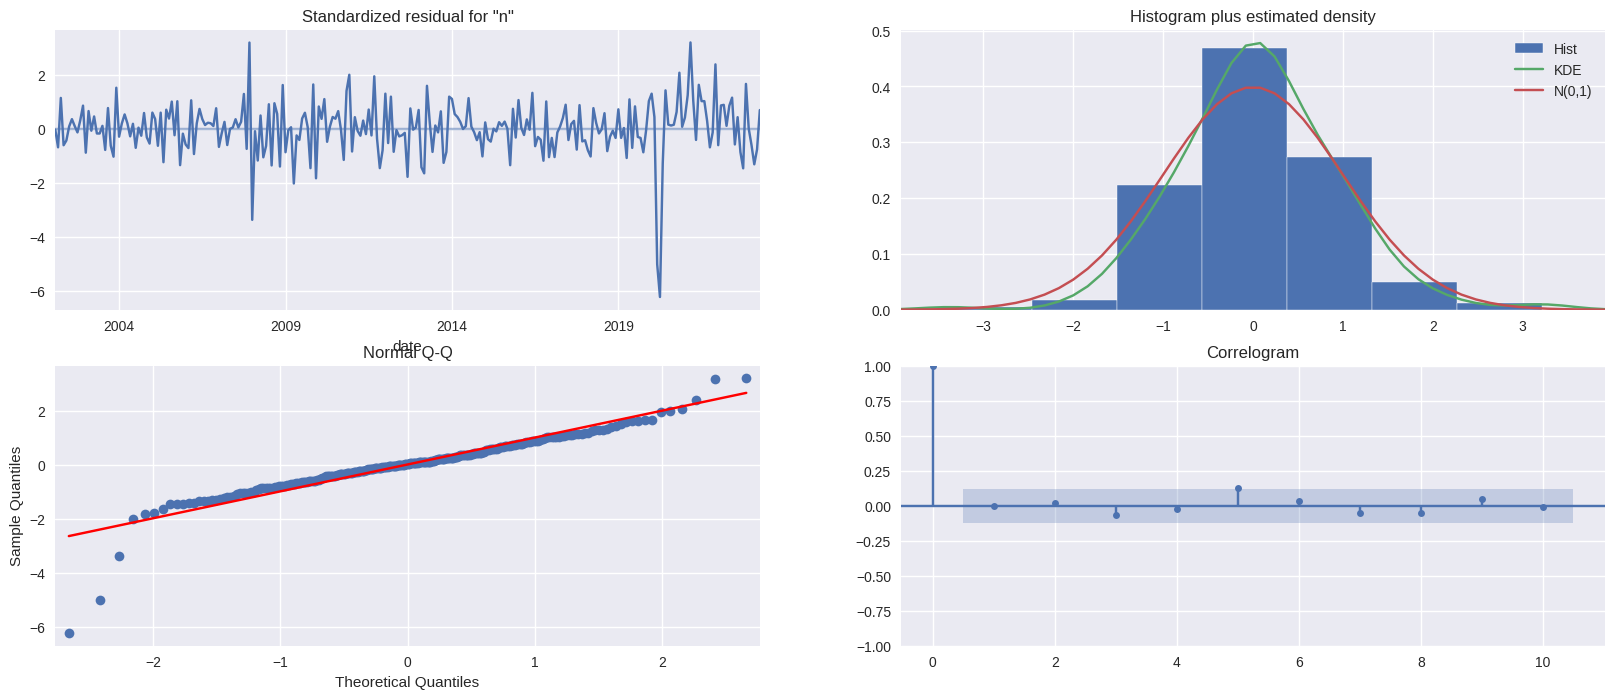

In [ ]:
plt.style.use('seaborn')
arima_result.plot_diagnostics(figsize=(20,8))
plt.show()

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2023-05-01    117.348103
2023-06-01    124.883794
2023-07-01    128.687576
2023-08-01    127.333470
2023-09-01    132.720179
2023-10-01    134.112863
2023-11-01    156.136777
2023-12-01    186.417774
2024-01-01    117.992202
2024-02-01    118.560911
2024-03-01    120.574083
2024-04-01    118.380939
Freq: MS, Name: ARIMA Predictions, dtype: float64

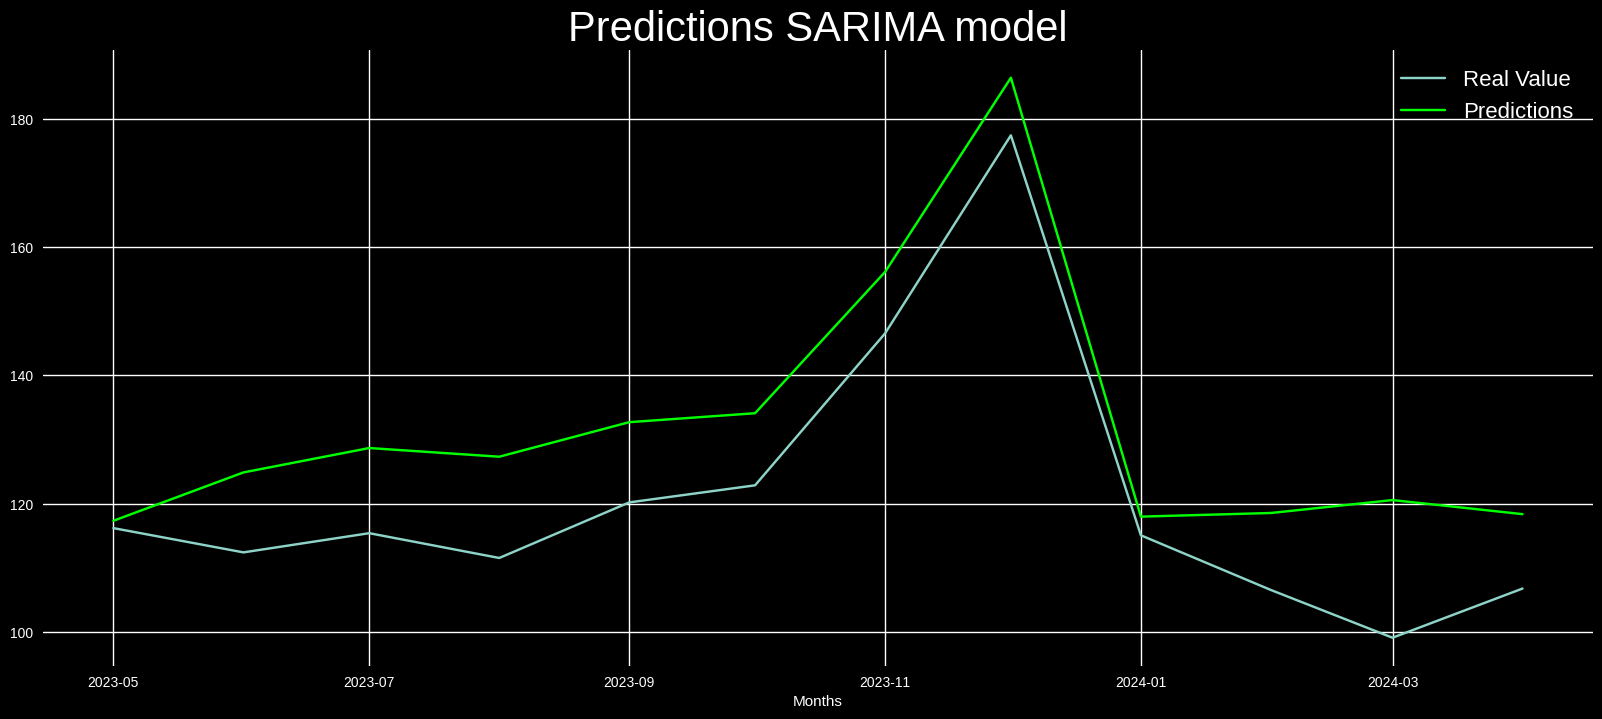

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["nominal_sales"], label="Real Value")
plt.plot(arima_pred, color="lime", label="Predictions")
plt.title("Predictions SARIMA model", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

In [ ]:
def evaluacion_metrica(y_true, y_pred,model_name):
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    MAPE=round(mean_absolute_percentage_error(y_true, y_pred)*100,4)
    R2= metrics.r2_score(y_true, y_pred)
    print('Evaluation metric results:-')
    print(f'MSE is : {MSE}')
    print(f'MAE is : {MAE}')
    print(f'RMSE is : {RMSE}')
    print(f'MAPE is : {MAPE}%')
    print(f'R2 is : {R2}',end='\n\n')
    return {
        'Modelo': model_name,
        'MSE': MSE,
        'MAE': MAE,
        'RMSE': RMSE,
        'MAPE': MAPE,
        'R2': R2
    }

In [ ]:
columns = ['Modelo', 'MSE', 'MAE', 'RMSE', 'MAPE', 'R2']
df_metrics = pd.DataFrame(columns=columns)

In [ ]:
metricasARIMA =evaluacion_metrica(test_data['nominal_sales'],arima_pred,'ARIMA')

Evaluation metric results:-
MSE is : 148.7353060699792
MAE is : 11.078914117096259
RMSE is : 12.195708510372786
MAPE is : 9.5985%
R2 is : 0.6419288739929466



In [ ]:
df_metrics.loc[len(df_metrics)] = metricasARIMA

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred
test_data

,nominal_sales,ARIMA_Predictions
date,,
2023-05-01,116.2044,117.348103
2023-06-01,112.4190,124.883794
2023-07-01,115.4120,128.687576
2023-08-01,111.5476,127.333470
2023-09-01,120.2116,132.720179
2023-10-01,122.8735,134.112863
2023-11-01,146.5633,156.136777
2023-12-01,177.4377,186.417774
2024-01-01,115.0803,117.992202


## ***Random Forest***

In [ ]:
def create_features(df,variable):
    df['month'] = df.index.month
    df['year'] = df.index.year
    for lag in range(1, 13):
        df[f'lag_{lag}'] = df[variable].shift(lag)
    return df.dropna()

In [ ]:
data.head()

,nominal_sales
date,
2001-01-01,33.0483
2001-02-01,38.2210
2001-03-01,48.7100
2001-04-01,47.8570
2001-05-01,56.2824


In [ ]:
data_rf = data.copy()

In [ ]:
data_rf

,nominal_sales
date,
2001-01-01,33.0483
2001-02-01,38.2210
2001-03-01,48.7100
2001-04-01,47.8570
2001-05-01,56.2824
...,...
2023-12-01,177.4377
2024-01-01,115.0803
2024-02-01,106.5562


In [ ]:
data_rf['nominal_sales_diff'] = data_rf['nominal_sales'].diff()
data_rf.dropna(inplace=True)
data_rf.head()

,nominal_sales,nominal_sales_diff
date,,
2001-02-01,38.2210,5.1727
2001-03-01,48.7100,10.4890
2001-04-01,47.8570,-0.8530
2001-05-01,56.2824,8.4254
2001-06-01,48.6065,-7.6759


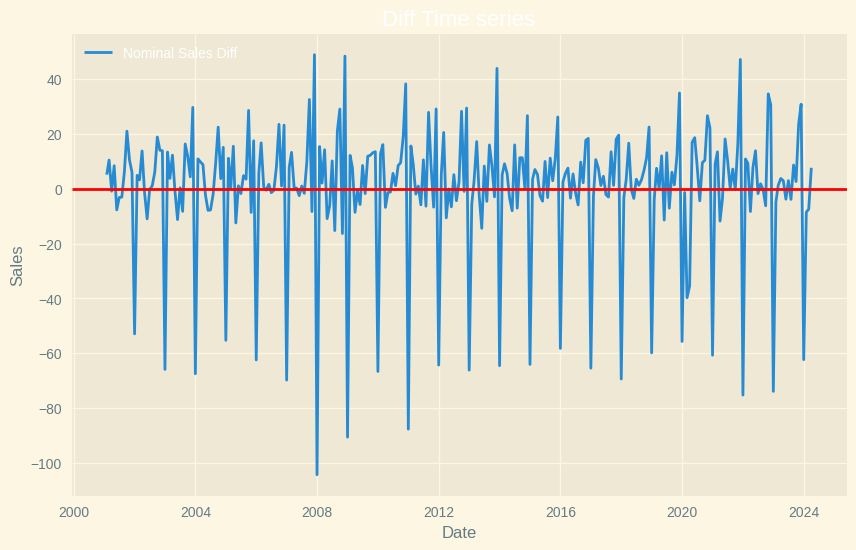

In [ ]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(10, 6))
plt.plot(data_rf.index, data_rf['nominal_sales_diff'], label='Nominal Sales Diff')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Diff Time series')
plt.legend()
plt.show()

In [ ]:
data_rf['nominal_diff_seasonal_diff'] = data_rf['nominal_sales_diff'].diff(periods=12)
data_rf.dropna(inplace=True)
data_rf.head()

,nominal_sales,nominal_sales_diff,nominal_diff_seasonal_diff
date,,,
2002-02-01,38.3124,4.9195,-0.2532
2002-03-01,41.5636,3.2512,-7.2378
2002-04-01,55.3728,13.8092,14.6622
2002-05-01,53.9501,-1.4227,-9.8481
2002-06-01,42.9877,-10.9624,-3.2865


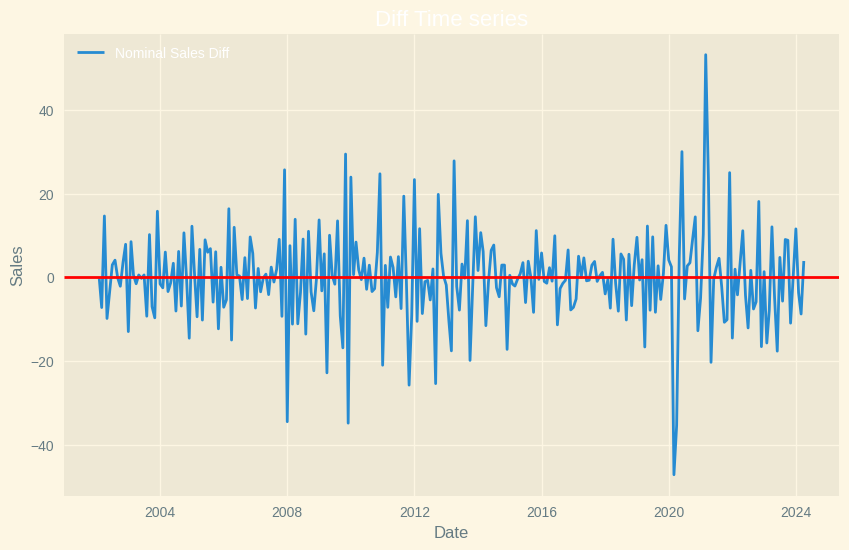

In [ ]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(10, 6))
plt.plot(data_rf.index, data_rf['nominal_diff_seasonal_diff'], label='Nominal Sales Diff')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Diff Time series')
plt.legend()
plt.show()

In [ ]:
data_rf = create_features(data_rf,'nominal_diff_seasonal_diff')
data_rf.head()

,nominal_sales,nominal_sales_diff,nominal_diff_seasonal_diff,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,,,,,
2003-02-01,44.4340,13.4371,8.5176,2,2003,-12.9849,7.8926,3.5573,-2.1398,-0.1590,4.0887,2.9679,-3.2865,-9.8481,14.6622,-7.2378,-0.2532
2003-03-01,48.2377,3.8037,0.5525,3,2003,8.5176,-12.9849,7.8926,3.5573,-2.1398,-0.1590,4.0887,2.9679,-3.2865,-9.8481,14.6622,-7.2378
2003-04-01,60.5060,12.2683,-1.5409,4,2003,0.5525,8.5176,-12.9849,7.8926,3.5573,-2.1398,-0.1590,4.0887,2.9679,-3.2865,-9.8481,14.6622
2003-05-01,59.6429,-0.8631,0.5596,5,2003,-1.5409,0.5525,8.5176,-12.9849,7.8926,3.5573,-2.1398,-0.1590,4.0887,2.9679,-3.2865,-9.8481
2003-06-01,48.4234,-11.2195,-0.2571,6,2003,0.5596,-1.5409,0.5525,8.5176,-12.9849,7.8926,3.5573,-2.1398,-0.1590,4.0887,2.9679,-3.2865


In [ ]:
X = data_rf.drop(columns=['nominal_diff_seasonal_diff','nominal_sales','nominal_sales_diff'])
y = data_rf['nominal_diff_seasonal_diff']

train_size = len(data_rf) - 12
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [ ]:
y_pred_diff = rf_model.predict(X_test)

In [ ]:
data_rf.tail(13)

,nominal_sales,nominal_sales_diff,nominal_diff_seasonal_diff,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,,,,,
2023-04-01,113.2497,3.7725,12.0643,4,2023,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819,1.6575,-12.1115,-4.3219,11.1341,3.4906
2023-05-01,116.2044,2.9547,-4.8048,5,2023,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819,1.6575,-12.1115,-4.3219,11.1341
2023-06-01,112.4190,-3.7854,-17.6662,6,2023,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819,1.6575,-12.1115,-4.3219
2023-07-01,115.4120,2.9930,4.7536,7,2023,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819,1.6575,-12.1115
2023-08-01,111.5476,-3.8644,-5.6999,8,2023,4.7536,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819,1.6575
2023-09-01,120.2116,8.6640,9.0374,9,2023,-5.6999,4.7536,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781,-7.5819
2023-10-01,122.8735,2.6619,8.8456,10,2023,9.0374,-5.6999,4.7536,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318,-5.8781
2023-11-01,146.5633,23.6898,-10.9673,11,2023,8.8456,9.0374,-5.6999,4.7536,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862,18.1318
2023-12-01,177.4377,30.8744,0.2404,12,2023,-10.9673,8.8456,9.0374,-5.6999,4.7536,-17.6662,-4.8048,12.0643,-7.9631,-15.7163,1.3376,-16.5862


In [ ]:
y_pred_diff_series = pd.Series(data=y_pred_diff, index=y_test.index, name='predicted_diff')
last_seasonal_values = data_rf['nominal_sales'].iloc[train_size - 12:train_size]
last_seasonal_values

date
2022-05-01    114.2052
2022-06-01    128.0860
2022-07-01    126.3254
2022-08-01    128.1609
2022-09-01    127.7875
2022-10-01    121.6038
2022-11-01    156.2609
2022-12-01    186.8949
2023-01-01    112.9599
2023-02-01    108.1365
2023-03-01    109.4772
2023-04-01    113.2497
Freq: MS, Name: nominal_sales, dtype: float64

In [ ]:
y_pred_original = list(last_seasonal_values)
for i in range(len(y_pred_diff)):
    current_value = y_pred_original[-12] + y_pred_diff[i]
    y_pred_original.append(current_value)
y_pred_original_series = pd.Series(data=y_pred_original[-12:], index=y_test.index, name='predicted_sales')

In [ ]:
metricasrf= evaluacion_metrica(test_data['nominal_sales'],y_pred_original_series,'RandomForest')

Evaluation metric results:-
MSE is : 108.30027919771317
MAE is : 9.392507616666668
RMSE is : 10.406742006877712
MAPE is : 7.9912%
R2 is : 0.739273720921662



In [ ]:
df_metrics.loc[len(df_metrics)] = metricasrf

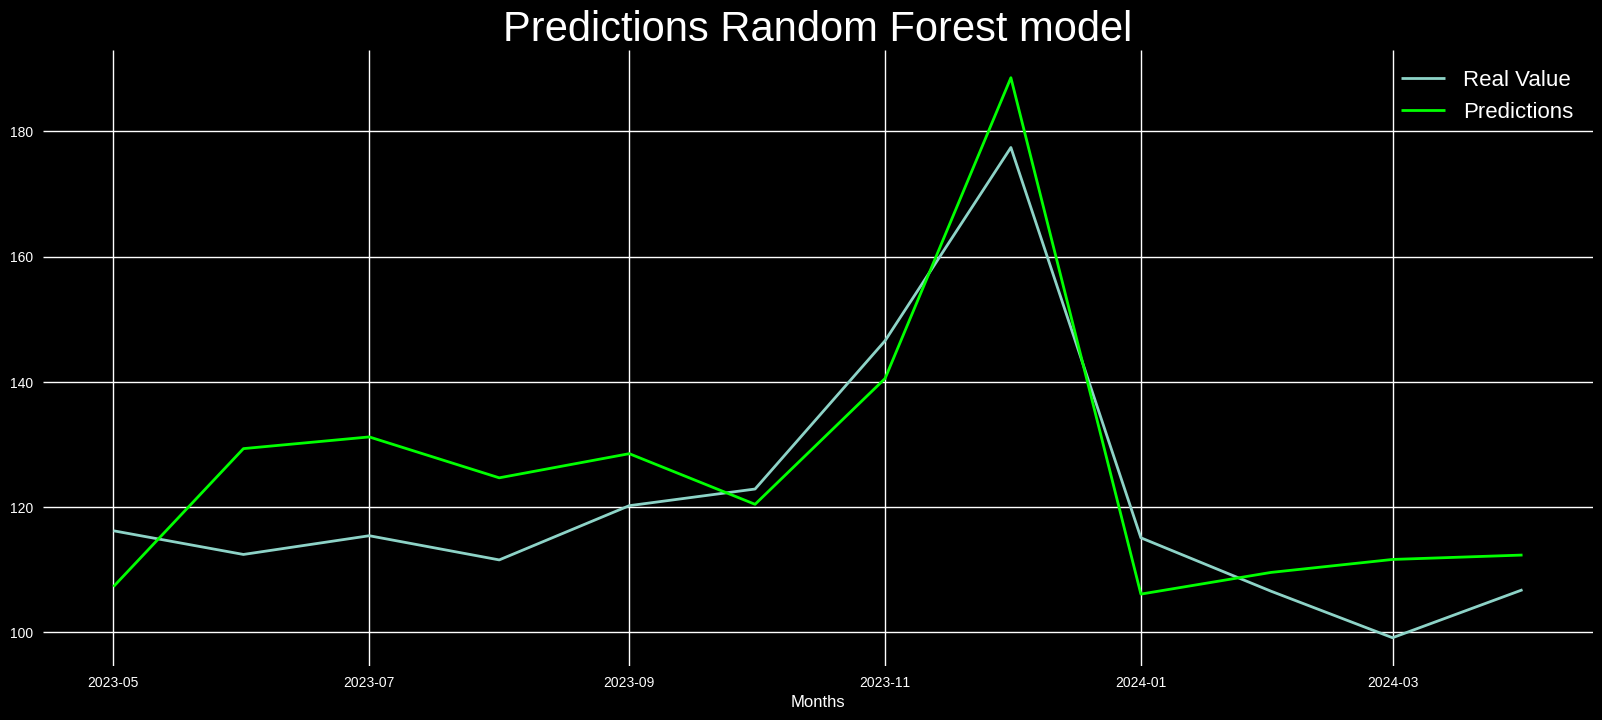

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data['nominal_sales'], label="Real Value")
plt.plot(y_pred_original_series, color="lime", label="Predictions")
plt.title("Predictions Random Forest model", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

In [ ]:
test_data['RF_Predictions'] = y_pred_original_series
test_data

,nominal_sales,ARIMA_Predictions,RF_Predictions
date,,,
2023-05-01,116.2044,117.348103,107.269669
2023-06-01,112.4190,124.883794,129.328845
2023-07-01,115.4120,128.687576,131.197851
2023-08-01,111.5476,127.333470,124.662762
2023-09-01,120.2116,132.720179,128.521337
2023-10-01,122.8735,134.112863,120.430815
2023-11-01,146.5633,156.136777,140.535173
2023-12-01,177.4377,186.417774,188.586691
2024-01-01,115.0803,117.992202,106.085570


## ***LSTM model***

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
data_lstm = data.copy()
data_lstm = scaler.fit_transform(data_lstm)

In [ ]:
tr_data = data_lstm[:len(data_lstm)-24]
vl_data = data_lstm[len(data_lstm)-24:]

In [ ]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(tr_data, tr_data, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(vl_data, vl_data, length=n_input, batch_size=1)

In [ ]:
model_LSTM = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])


In [ ]:
model_LSTM.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [ ]:
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 128)           66560     
                                                                 
 dropout_6 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 120193 (469.50 KB)
Trainable params: 120

In [ ]:
history = model_LSTM.fit(train_generator, epochs=50, validation_data=val_generator,verbose=1)

Epoch 1/50
244/244 [==============================] - 9s 36ms/step - loss: 0.0061 - mean_absolute_percentage_error: 1702185.6250 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 11.1298
Epoch 2/50
244/244 [==============================] - 5s 21ms/step - loss: 0.0075 - mean_absolute_percentage_error: 1758033.6250 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 5.7212
Epoch 3/50
244/244 [==============================] - 6s 26ms/step - loss: 0.0097 - mean_absolute_percentage_error: 1787070.2500 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 11.7640
Epoch 4/50
244/244 [==============================] - 6s 26ms/step - loss: 0.0060 - mean_absolute_percentage_error: 1590456.0000 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 16.3839
Epoch 5/50
244/244 [==============================] - 5s 20ms/step - loss: 0.0061 - mean_absolute_percentage_error: 1579283.6250 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 5.5118
Epoch 6/50
244/244 [============

In [ ]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

In [ ]:
val_predictions = model_LSTM.predict(val_generator)

12/12 [==============================] - 1s 10ms/step


In [ ]:
val_predictions = scaler.inverse_transform(val_predictions)

In [ ]:
val_predictions

array([[109.963425],
       [120.47171 ],
       [118.91617 ],
       [120.34763 ],
       [119.94201 ],
       [120.14258 ],
       [141.25183 ],
       [143.39246 ],
       [107.33159 ],
       [103.93177 ],
       [106.28976 ],
       [109.07261 ]], dtype=float32)

In [ ]:
metricasLSTM = evaluacion_metrica(test_data['nominal_sales'],val_predictions,'LSTM')

Evaluation metric results:-
MSE is : 125.99909116219334
MAE is : 7.399543295288087
RMSE is : 11.22493167739534
MAPE is : 5.6082%
R2 is : 0.6966649167542991



In [ ]:
df_metrics.loc[len(df_metrics)] = metricasLSTM

In [ ]:
test_data['LSTM_Predictions'] = val_predictions
test_data

,nominal_sales,ARIMA_Predictions,RF_Predictions,LSTM_Predictions
date,,,,
2023-05-01,116.2044,117.348103,107.269669,109.963425
2023-06-01,112.4190,124.883794,129.328845,120.471710
2023-07-01,115.4120,128.687576,131.197851,118.916168
2023-08-01,111.5476,127.333470,124.662762,120.347633
2023-09-01,120.2116,132.720179,128.521337,119.942009
2023-10-01,122.8735,134.112863,120.430815,120.142578
2023-11-01,146.5633,156.136777,140.535173,141.251831
2023-12-01,177.4377,186.417774,188.586691,143.392456
2024-01-01,115.0803,117.992202,106.085570,107.331589


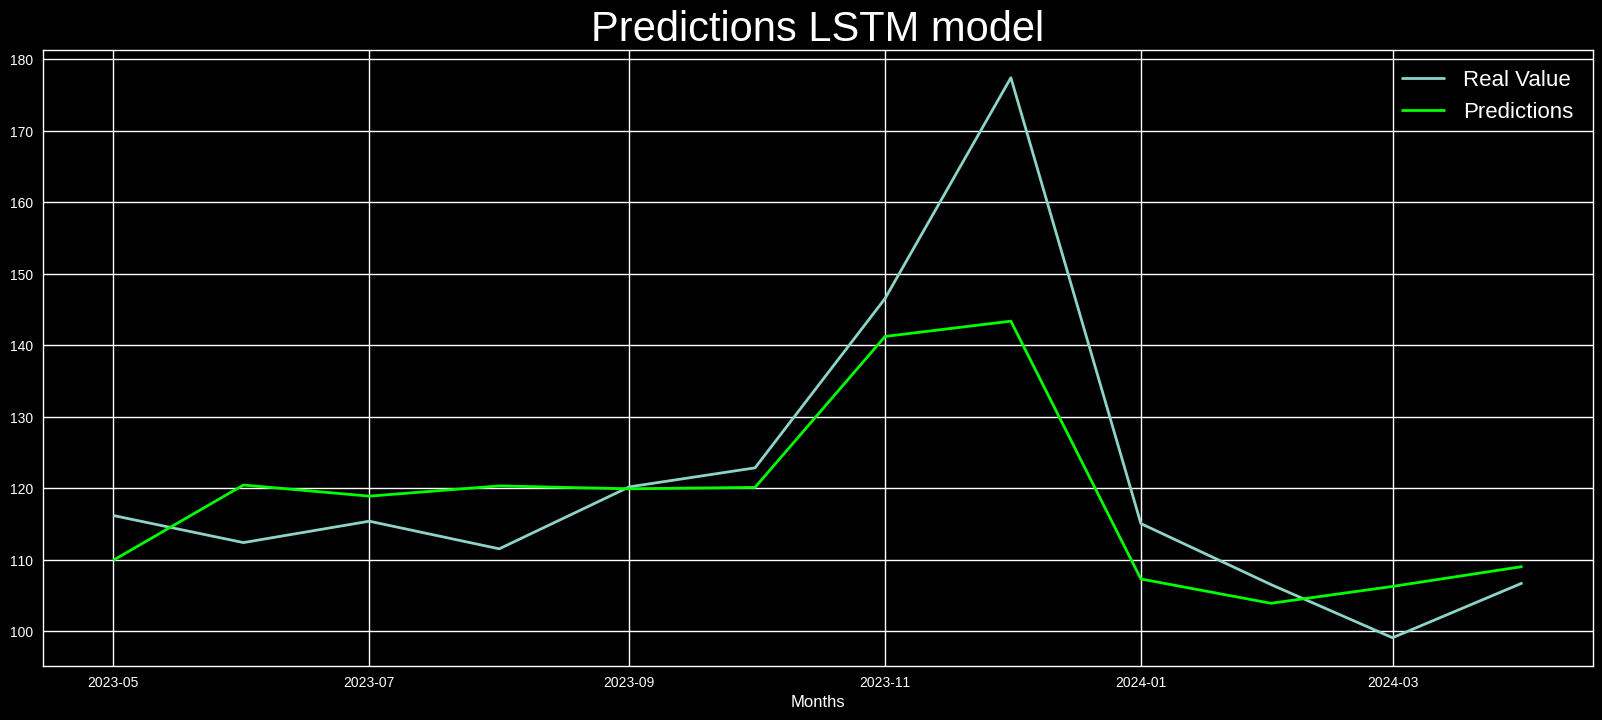

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(test_data['nominal_sales'], label="Real Value")
plt.plot(test_data['LSTM_Predictions'], color="lime", label="Predictions")
plt.title("Predictions LSTM model", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

## ***Prophet***

In [ ]:
data_p = data.copy()
data_p = data_p.reset_index()
data_p.head()

,date,nominal_sales
0,2001-01-01,33.0483
1,2001-02-01,38.2210
2,2001-03-01,48.7100
3,2001-04-01,47.8570
4,2001-05-01,56.2824


In [ ]:
data_p = data_p.rename(columns={"date":"ds", "nominal_sales":"y"} )
data_p.head()

,ds,y
0,2001-01-01,33.0483
1,2001-02-01,38.2210
2,2001-03-01,48.7100
3,2001-04-01,47.8570
4,2001-05-01,56.2824


In [ ]:
n= len(data_p)
train_data_pr = data_p.iloc[:n-12]
test_data_pr = data_p.iloc[n-12:]

In [ ]:
m = Prophet()
m.fit(train_data_pr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx5f89rku/py8cfeyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx5f89rku/qm5bp0t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96034', 'data', 'file=/tmp/tmpx5f89rku/py8cfeyn.json', 'init=/tmp/tmpx5f89rku/qm5bp0t6.json', 'output', 'file=/tmp/tmpx5f89rku/prophet_model2chumnjm/prophet_model-20240704023037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [ ]:
prophet_pred.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
268,2023-05-01,107.288709,82.655024,116.585659,107.288709,107.288709,-7.576185,-7.576185,-7.576185,-7.576185,-7.576185,-7.576185,0.0,0.0,0.0,99.712524
269,2023-06-01,107.413143,81.048983,114.181904,107.413129,107.413143,-10.305414,-10.305414,-10.305414,-10.305414,-10.305414,-10.305414,0.0,0.0,0.0,97.107729
270,2023-07-01,107.533562,84.460256,117.384235,107.531242,107.535349,-6.223444,-6.223444,-6.223444,-6.223444,-6.223444,-6.223444,0.0,0.0,0.0,101.310119
271,2023-08-01,107.657996,81.410058,114.785972,107.652729,107.663709,-9.323224,-9.323224,-9.323224,-9.323224,-9.323224,-9.323224,0.0,0.0,0.0,98.334772
272,2023-09-01,107.782430,90.992460,124.907772,107.773149,107.792157,0.796133,0.796133,0.796133,0.796133,0.796133,0.796133,0.0,0.0,0.0,108.578562
273,2023-10-01,107.902849,104.847139,137.519231,107.888272,107.920674,13.395128,13.395128,13.395128,13.395128,13.395128,13.395128,0.0,0.0,0.0,121.297977
274,2023-11-01,108.027283,112.968847,146.062377,108.005054,108.052525,20.871958,20.871958,20.871958,20.871958,20.871958,20.871958,0.0,0.0,0.0,128.899241
275,2023-12-01,108.147702,139.397465,173.442581,108.119187,108.181922,48.094279,48.094279,48.094279,48.094279,48.094279,48.094279,0.0,0.0,0.0,156.241982
276,2024-01-01,108.272136,70.966920,104.346100,108.236928,108.313161,-20.586060,-20.586060,-20.586060,-20.586060,-20.586060,-20.586060,0.0,0.0,0.0,87.686076
277,2024-02-01,108.396569,77.233599,110.390390,108.353393,108.447382,-14.492904,-14.492904,-14.492904,-14.492904,-14.492904,-14.492904,0.0,0.0,0.0,93.903666


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred.index.freq = "MS"

In [ ]:
prophet_pred

,Pred
Date,
2023-05-01,99.712524
2023-06-01,97.107729
2023-07-01,101.310119
2023-08-01,98.334772
2023-09-01,108.578562
2023-10-01,121.297977
2023-11-01,128.899241
2023-12-01,156.241982
2024-01-01,87.686076


In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [ ]:
prophetmetrics = evaluacion_metrica(test_data['nominal_sales'],test_data["Prophet_Predictions"],'Prophet')

Evaluation metric results:-
MSE is : 226.6016866149532
MAE is : 13.098650004126824
RMSE is : 15.05329487570589
MAPE is : 10.6768%
R2 is : 0.45447033911949597



In [ ]:
df_metrics.loc[len(df_metrics)] = prophetmetrics

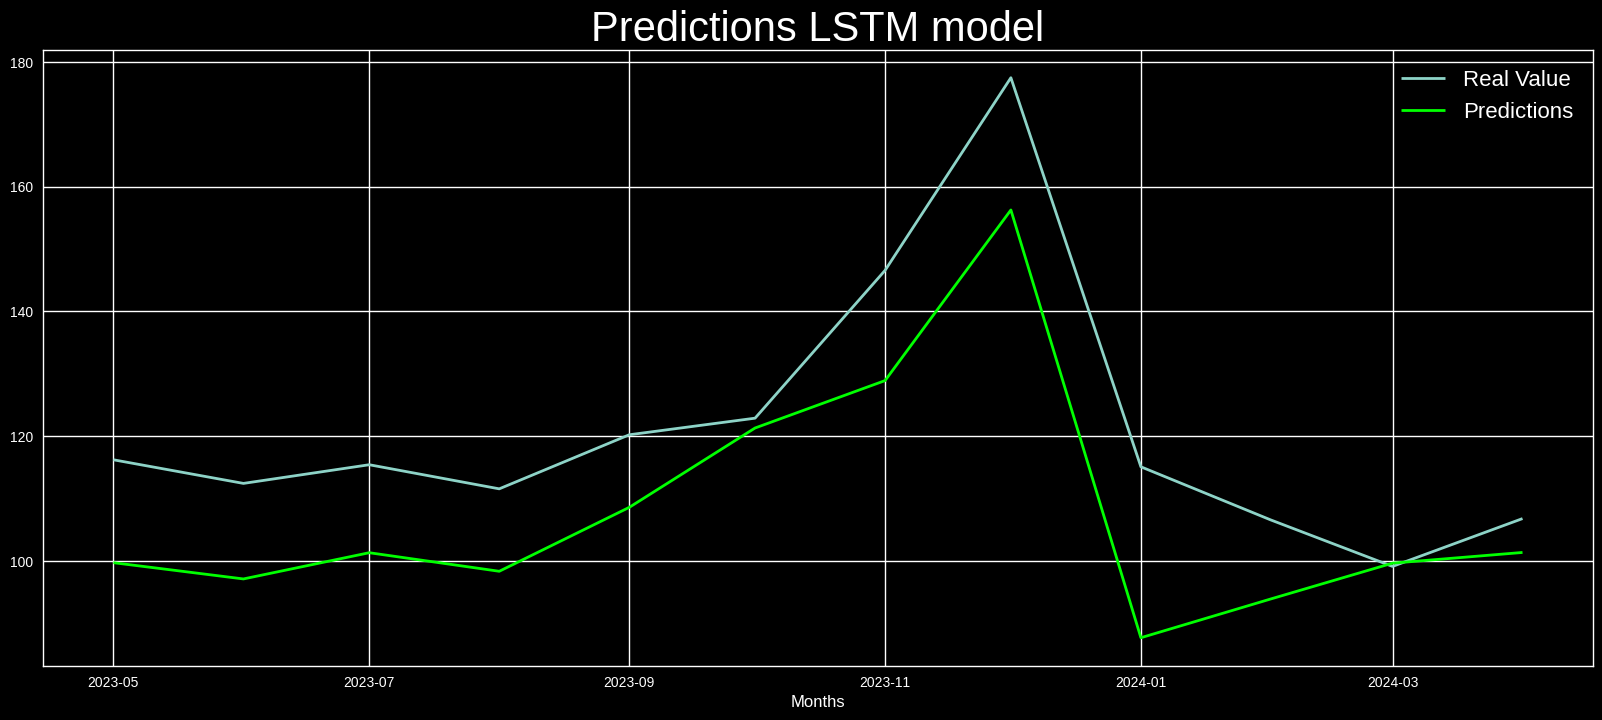

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(test_data['nominal_sales'], label="Real Value")
plt.plot(test_data['Prophet_Predictions'], color="lime", label="Predictions")
plt.title("Predictions Prophet model", fontsize=30);
plt.xlabel('Months')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

In [ ]:
test_data

,nominal_sales,ARIMA_Predictions,RF_Predictions,LSTM_Predictions,Prophet_Predictions
date,,,,,
2023-05-01,116.2044,117.348103,107.269669,109.963425,99.712524
2023-06-01,112.4190,124.883794,129.328845,120.471710,97.107729
2023-07-01,115.4120,128.687576,131.197851,118.916168,101.310119
2023-08-01,111.5476,127.333470,124.662762,120.347633,98.334772
2023-09-01,120.2116,132.720179,128.521337,119.942009,108.578562
2023-10-01,122.8735,134.112863,120.430815,120.142578,121.297977
2023-11-01,146.5633,156.136777,140.535173,141.251831,128.899241
2023-12-01,177.4377,186.417774,188.586691,143.392456,156.241982
2024-01-01,115.0803,117.992202,106.085570,107.331589,87.686076


In [ ]:
fig = px.line(test_data, x=test_data.index, y=test_data.columns,template = "plotly_dark",
              title="Predicciones")
fig.show()

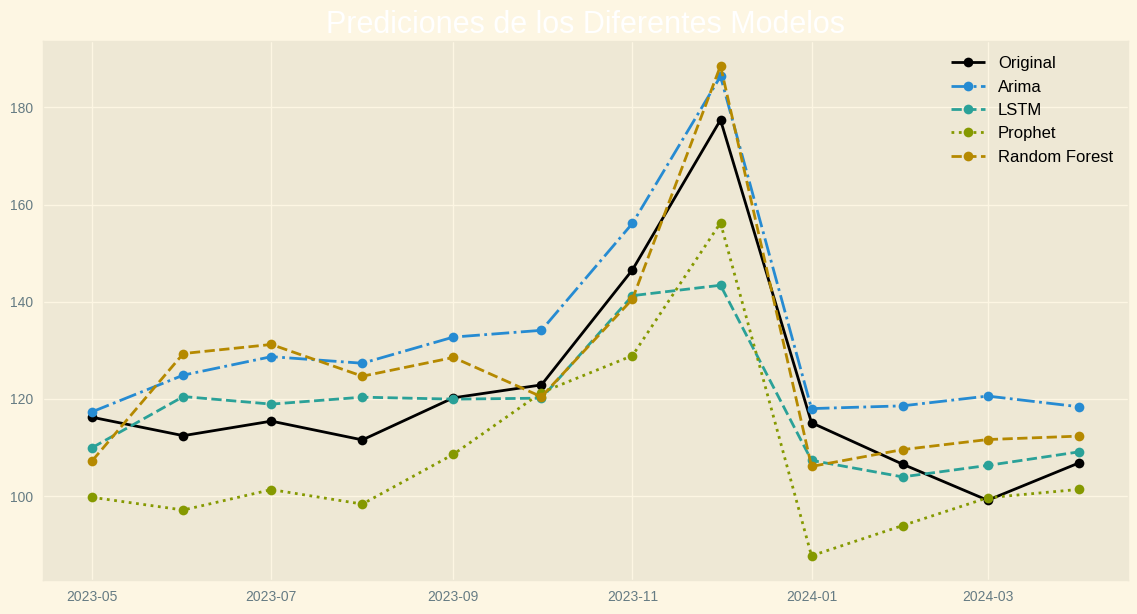

In [ ]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(14,7))
plt.plot_date(test_data.index, test_data["nominal_sales"],label="Original", linestyle="-",color="black")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], label="Arima",linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"],label="LSTM", linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], label="Prophet",linestyle=":")
plt.plot_date(test_data.index, test_data["RF_Predictions"], label="Random Forest",linestyle="--")
plt.legend(fontsize=12)
plt.setp(plt.gca().get_legend().get_texts(), color='black')
plt.title("Prediciones de los Diferentes Modelos", fontsize=22)
plt.show();

In [ ]:
df_metrics

,Modelo,MSE,MAE,RMSE,MAPE,R2
0,ARIMA,148.735306,11.078914,12.195709,9.5985,0.641929
1,RandomForest,108.300279,9.392508,10.406742,7.9912,0.739274
2,LSTM,125.999091,7.399543,11.224932,5.6082,0.696665
3,Prophet,226.601687,13.098650,15.053295,10.6768,0.454470
